# SIMPLE WORKING VERSION

### TRYING TO CONVERT TO DATALOADER USING THIS LINK:
https://github.com/yunjey/seq2seq-dataloader/blob/master/data_loader.py

https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L15/migration_tutorial.ipynb

https://medium.com/@bitdribble/migrate-torchtext-to-the-new-0-9-0-api-1ff1472b5d71

# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda:0'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
type(train)

torchtext.data.datasets_utils._ParseSQuADQAData

In [7]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [8]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [9]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [10]:
train_len = 30000
test_len = 3000

In [11]:
train_df = sample_df_num(train_df, train_len)

In [12]:
test_df = sample_df_num(test_df, test_len)

In [13]:
#train_df = sample_df_perc(train_df, 1)

In [13]:
train_df.shape, test_df.shape

((30000, 2), (3000, 2))

In [14]:
train_df.head(3)

,Question,Answer
0,How many World Heritage Sites can be found in ...,four
1,When was a church first founded at the site?,7th century
2,What did the soviets opposed rebuilding?,rebuilding of western Europe


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [15]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

What religious festival is also known as the festival of light?
['what', 'religious', 'festival', 'also', 'known', 'festival', 'light']
['what', 'religi', 'festiv', 'also', 'known', 'festiv', 'light']


In [16]:
from modules.vocab import Vocab

In [17]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [18]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [19]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
23235,Which single was released as the album's lead ...,4 Minutes,"[which, singl, releas, album, lead, singl]","[4, minutes]"
23531,What school practices were kept by the Roman w...,scholarly tradition of the Greek academies was...,"[what, school, practic, kept, roman, world, fa...","[scholarly, tradition, greek, academies, maint..."
16611,What type of government came from the coalitio...,first notable form of self-government,"[what, type, govern, came, coalit, tradit, pat...","[first, notable, form, selfgovernment]"


In [20]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [21]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [22]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [23]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [24]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [25]:
Q_vocab.n_words, A_vocab.n_words, 

(17137, 22504)

In [26]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [27]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(18169, 23928)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [28]:
from modules.stats import sentences_stats, histograms

In [29]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.44
	         median: 6.00
	         minimum: 1
	         maximum: 24)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [30]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.58
	         median: 6.00
	         minimum: 2
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.34
	         median: 2.00
	         minimum: 0
	         maximum: 15)


### Remove the least common words from the sentences

In [31]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [32]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 9149 words that occur only once, answers vocabulary has 14428 such words


### Create lists of those words and remove them from the sequences

In [33]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [34]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [35]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [36]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.16
	         median: 6.00
	         minimum: 0
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 1.99
	         median: 2.00
	         minimum: 0
	         maximum: 17)


In [37]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.30
	         median: 6.00
	         minimum: 1
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 1.91
	         median: 2.00
	         minimum: 0
	         maximum: 14)


### Remove questions that have less than three words and answers that have less than one

In [38]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


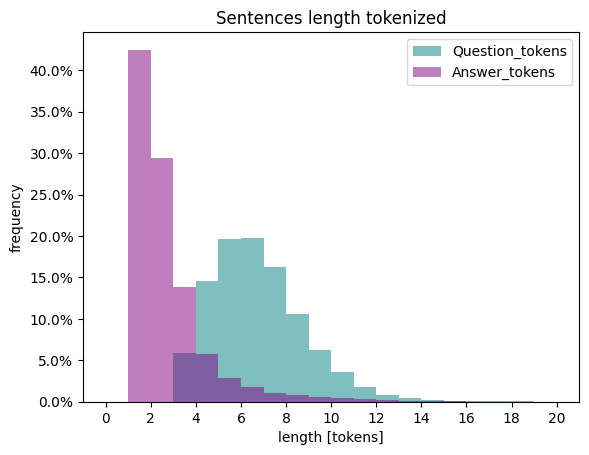

In [39]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [40]:
train_df_final.shape

(25798, 4)

In [41]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.26
	         median: 6.00
	         minimum: 3
	         maximum: 21)
Sentences in column Answer_tokens:
	         mean: 2.26
	         median: 2.00
	         minimum: 1
	         maximum: 17)


In [42]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


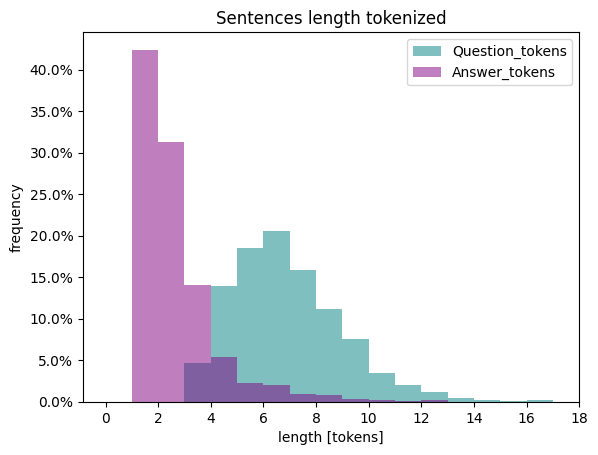

In [43]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [44]:
test_df_final.shape

(2600, 4)

In [45]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.40
	         median: 6.00
	         minimum: 3
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 2.15
	         median: 2.00
	         minimum: 1
	         maximum: 14)


### Remove long outliers: long sentences that occure rarely

In [46]:
# keeping only the 95% of the data
cutoff = 95

In [47]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [48]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [49]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [50]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.06
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.99
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [51]:
# to simplify I'm using the same thresholds for the test set

In [52]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [53]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.18
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.97
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [54]:
train_df_final.shape, test_df_final.shape

((23923, 4), (2422, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [55]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [56]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [57]:
len(train_pairs_final), len(test_pairs_final)

(23923, 2422)

In [58]:
train_pairs_final[0]

Pair(question=['how', 'mani', 'world', 'heritag', 'site', 'found', 'london'], answer=['four'])

In [59]:
from torch.utils.data import DataLoader, Dataset

In [60]:
def to_tensor_new(vocab, tokens, seq_len, padding):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    Allows to choose to pad either at the beginning or at the end'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    if padding == 'end':
    
        padded = [[vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens))]
        
    else:
    
        padded = [vocab.word2index['PAD']] * (seq_len-len(tokens)) + [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']]

    tensor = torch.Tensor(padded).long().view(-1,1)
    
    return tensor

In [61]:
Pair = namedtuple('Pair', ['question', 'answer'])
def get_tensor_pairs_from_df(df, cols, q_vocab, q_max_len, a_vocab, a_max_len, padding):
    '''returns a list of named tuples (question, answer)'''
    dicts = []
    for col in cols:
        dicts.append(df[col].to_dict().values())
    
    return [Pair(to_tensor_new(q_vocab, q, q_max_len, padding), to_tensor_new(a_vocab, a, a_max_len, padding)) for q, a in zip(*dicts)]

In [62]:
train_tensor_pairs_final = get_tensor_pairs_from_df(train_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX, 'end')

In [63]:
test_tensor_pairs_final = get_tensor_pairs_from_df(test_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX, 'end')

In [64]:
train_tensor_pairs_final[0]

Pair(question=tensor([[1],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9],
        [2],
        [0],
        [0],
        [0]]), answer=tensor([[1],
        [3],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0]]))

In [65]:
len(test_tensor_pairs_final)

2422

In [66]:
class MyDataset(Dataset):
    def __init__(self, pairs):
        self.source_data = [p.question for p in pairs]
        self.target_data = [p.answer for p in pairs]
            
    def __getitem__(self, idx):
        return self.source_data[idx], self.target_data[idx]
    
    def __len__(self):
        return len(self.source_data)

In [67]:
train_dataset = MyDataset(train_tensor_pairs_final)

In [68]:
test_dataset = MyDataset(test_tensor_pairs_final)

In [69]:
train_dl = DataLoader(train_dataset, batch_size = 4, shuffle = True)

In [70]:
test_dl = DataLoader(test_dataset, batch_size = 4, shuffle = False)

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [71]:
import torch
import torch.nn as nn

## ENCODER

In [72]:
class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        # embedding step
        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)        
        x = x.view(1, 1, -1)        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

## DECODER

In [73]:
class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        # embedding
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # fully connected linear layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        # softmax
        self.softmax = nn.LogSoftmax(dim=1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

## SEQ2SEQ

In [74]:
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        # make encoder and decoder 
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
                
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        # target batch (answers) is unpacked to maximum length and batch size
        max_len, batch_size = trg_batch.shape               
        
        
        
        #print(f'Seq len: {max_len}, batch size {batch_size}, src_batch {src_batch.shape}, trg_batch {trg_batch.shape}')

        # WHAT IS THE DIFFERENCE BETWEEN max_len and trg_len here???
        
        trg_vocab_size = self.decoder.output_size
        
        # print(f"trg_vocab_size: {trg_vocab_size}")
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

        # print(f"outputs size (tensor to store decoder's outputs): {outputs.shape}")
              
         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        
        # iterate over the length of the source (question sequence) using the encoder
        
        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            
            # src_batch[i] is the ith token of the input (question)
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        # trg_batch[0] that's just the first element of trg_batch        
        trg = trg_batch[0]
        
        
        # now iterating over the target length, using the decoder
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            
            # here we use the teacher forcing: if the random value is less than the ratio, then the target is just an element of the target (token from the answer)
            # otherwise it's the highest probability prediction
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
trg_vocab_size: 23669
outputs size (tensor to store decoder's outputs): torch.Size([8, 1, 23669])

In [94]:
from torch.nn.parallel import DistributedDataParallel, DataParallel

### Model parameters

In [95]:
embedding_dim = 256
hidden_size = 256
#dropout = 0.5

### Hyperparameters

In [96]:
learning_rate = 0.005
num_epochs = 50

### Model

In [97]:
#seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, dropout=dropout, device=device)
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [98]:
torch.cuda.device_count()

2

In [99]:
[d for d in range(torch.cuda.device_count())]

[0, 1]

In [100]:
seq2seq = DataParallel(seq2seq, device_ids=[d for d in range(torch.cuda.device_count())])

In [101]:
#seq2seq = 
seq2seq.to(device)

DataParallel(
  (module): Seq2Seq(
    (encoder): Encoder(
      (embedding): Embedding(18169, 256)
      (lstm): LSTM(256, 256)
    )
    (decoder): Decoder(
      (embedding): Embedding(23928, 256)
      (lstm): LSTM(256, 256)
      (fc): Linear(in_features=256, out_features=23928, bias=True)
      (softmax): LogSoftmax(dim=1)
    )
  )
)

### Optimizer and loss function

In [102]:
from torch import optim
import torch.nn as nn

In [103]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

In [104]:
seq2seq.device_ids

[0, 1]

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [105]:
total_train_loss = []
total_test_loss = []

In [106]:
import torch
import torch.nn as nn

In [107]:
def train(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio = 0.5, print_every = 1000): 
    
    model.train() # Set the model to training mode

    total_loss = 0

    count = 0

    for batch in dataloader:

        src_tensor, tgt_tensor = batch
        
        src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device)

        src_tensor, tgt_tensor = src_tensor.reshape(-1,1), tgt_tensor.reshape(-1,1)
        
        
        # print(src_tensor.shape, tgt_tensor.shape)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=teacher_forcing_ratio)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1 

        if count % print_every == 0:
            print(f'Loss {total_loss/count}')

    return total_loss / len(dataloader)

In [108]:
def evaluate(model, dataloader, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:

            src_tensor, tgt_tensor = batch

            src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device)

            src_tensor, tgt_tensor = src_tensor.reshape(-1,1), tgt_tensor.reshape(-1,1)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
            
            total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [109]:
import matplotlib.pyplot as plt

In [136]:
# trying with teacher forcing ratio 0.5

In [111]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_dl, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_dl, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



IndexError: Caught IndexError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/shared/home/u076079/envs/lstm_chatbot/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/shared/home/u076079/envs/lstm_chatbot/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_15054/699282883.py", line 48, in forward
    _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
IndexError: index 24 is out of bounds for dimension 0 with size 24
